In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox, probplot
import matplotlib.pyplot as plt

import dask.dataframe as dd
import datetime
from datetime import date

import utils

In [2]:
path_train = 'data_train.csv'
path_test = 'data_test.csv'
path_features = 'features.csv'

In [3]:
data_train = utils.prepare_func(path_train, path_features)

In [4]:
data_test = utils.prepare_func(path_test, path_features)

In [5]:
data_train.head()

,id,vas_id,buy_time_x,target,0,1,2,3,4,5,...,245,246,247,248,249,250,251,252,month,number_of_week
822009,233938,2.0,1546203600,0.0,136.950029,738.710888,140.379214,730.593202,134.961754,709.48821,...,-25.996269,-37.630448,-294.747724,34.167111,-0.694428,-12.175933,-0.45614,1.0,12,4
825277,1526778,2.0,1546203600,0.0,-84.089971,-268.349112,-98.030786,-320.956798,-103.448246,-342.06179,...,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,12,4
852324,3336483,2.0,1546203600,0.0,-90.699971,-99.359112,-104.640786,-151.966798,-110.058246,-173.07179,...,-21.996269,-36.630448,771.252276,-21.832889,-0.694428,-12.175933,-0.45614,0.0,12,4
845060,2453583,2.0,1546203600,0.0,-96.799971,100.290888,-110.740786,47.683202,-116.158246,26.57821,...,-25.996269,-37.630448,1168.252276,381.167111,-0.694428,169.824067,-0.45614,0.0,12,4
849327,133439,4.0,1546203600,0.0,-75.609971,176.580888,-89.550786,135.833202,-94.968246,114.72821,...,-25.996269,-37.630448,-303.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,12,4


In [6]:
data_test.head()

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,245,246,247,248,249,250,251,252,month,number_of_week
48190,3793438,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
5776,3256899,2.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
43610,1766065,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
6733,3040181,6.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
6746,3427825,5.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


### 1 Разделяем на train и test

In [7]:
X = data_train.drop('target', axis=1)
y = data_train['target']

0.0    0.930973
1.0    0.069027
Name: target, dtype: float64

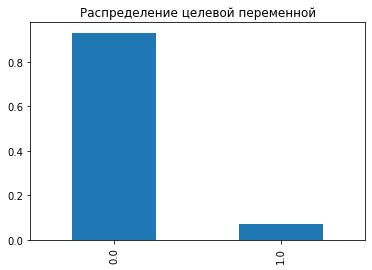

In [8]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [9]:
from sklearn.model_selection import train_test_split

# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

In [10]:
print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.931077
1.0    0.068923
Name: target, dtype: float64

Test
0.0    0.930662
1.0    0.069338
Name: target, dtype: float64


### 2 Pipeline для baseline модели

In [11]:
#!pip install catboost

In [12]:
import catboost as catb

In [13]:
catb_model = ('catb_model', catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'))

In [14]:
from sklearn.impute import SimpleImputer

In [15]:
step_imputer = ("imputer", SimpleImputer(strategy="mean"))

In [16]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_imputer,
    catb_model
])

### 3 Кросс-валидация

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [18]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.93 (+/- 0.00)


### 4 Графики и метрики baseline модели на тесте

In [19]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

#### Распределение предсказаний baseline модели

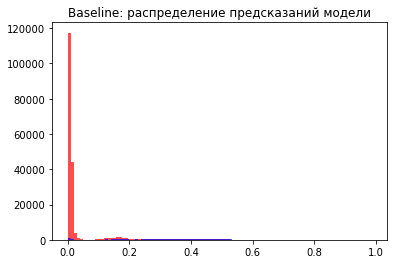

In [20]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

#### Roc и PR Кривые

In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.932


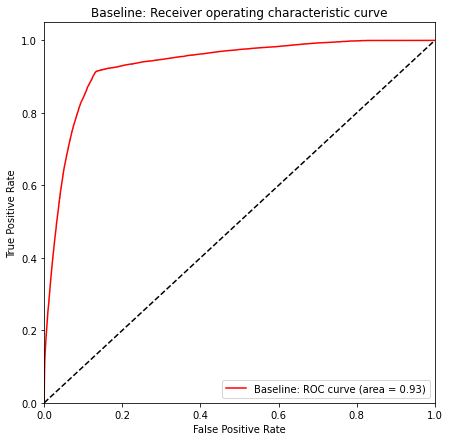

In [22]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.554


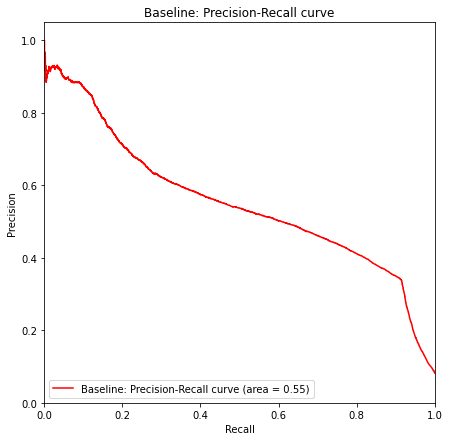

In [23]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

#### Матрица смежности

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[189626   2417]
 [ 10180   4128]]


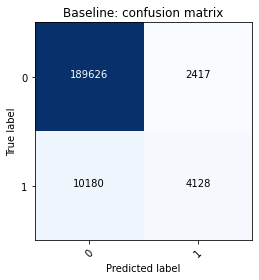

In [25]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [26]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.94
           1 precision = 0.63
              1 recall = 0.29
   micro avg precision = 0.94 
   macro avg precision = 0.79 
weighted avg precision = 0.93 


# 5 Определение типа признаков

In [27]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [28]:
X_nunique.shape

(258,)

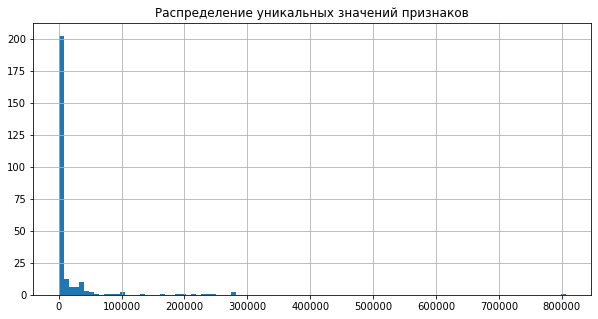

In [29]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [30]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

#### константные признаки

In [31]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### вещественные признаки

In [32]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [33]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

6

#### бинарные

In [34]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\548895597.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_binary = set(X.loc[:, f_other].columns[(
C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\548895597.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].max() == 1) & \
C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\548895597.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].min() == 0) & \
C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\548895597.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  (X.loc[:, f_other].isnull().sum() == 0))])


0

In [35]:
f_other = f_other - f_binary
len(f_other)

6

#### категориальные

In [36]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\1387870911.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
C:\Users\Анна\AppData\Local\Temp\ipykernel_19176\1387870911.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())


In [37]:
f_other = f_other - f_categorical
len(f_other)

3

In [38]:
f_numeric = f_numeric | f_other

In [39]:
f_other = f_other - f_numeric
len(f_other)

0

In [40]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [41]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 5
f_binary: 0
f_categorical: 3
f_numeric: 250


# 6 sklearn.Pipeline

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

In [43]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### 7 Пайплайн обработки признаков


In [44]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [45]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [46]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

269

### 8 Выбор модели


In [47]:
def training(classifier):
    from sklearn.metrics import roc_auc_score

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    # расчтаем метрики
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    roc_auc_score = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)
    
 
    return [round(i, 3) for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score]]

In [48]:
#!pip install lightgbm

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

In [75]:
results = pd.DataFrame([
    training(classifier = make_pipeline(f_prep_pipeline, LogisticRegression(random_state=RANDOM_STATE))),
    training(classifier = make_pipeline(f_prep_pipeline, RandomForestClassifier(random_state=RANDOM_STATE))),
    training(classifier = make_pipeline(f_prep_pipeline, DecisionTreeClassifier(random_state=RANDOM_STATE))),
    training(classifier = make_pipeline(f_prep_pipeline, catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'))),
    training(classifier = make_pipeline(f_prep_pipeline, GradientBoostingClassifier(random_state=RANDOM_STATE))),
    training(classifier = make_pipeline(f_prep_pipeline, lgb.LGBMClassifier(random_state=RANDOM_STATE))),
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC'])

results['models'] = ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'CatBoostClassifier', 'GradientBoostingClassifier', 'LGBMClassifier']
results = results.set_index('models')

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Анна\AppData\Local\Temp\ipykernel_14004\1603296245.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
C:\Users\Анна\AppData\Local\Temp\ipykernel_14004\1603296245.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
C:\Users\Анна\AppData\Local\Temp\ipykernel_14004\1603296245.py:11: RuntimeWarning: invalid value enco

In [76]:
results

,Best Threshold,F,Precision,Recall,ROC AUC
models,,,,,
LogisticRegression,0.945,NaN,0.000,0.000,0.908
RandomForestClassifier,0.270,0.511,0.418,0.658,0.869
DecisionTreeClassifier,1.000,0.404,0.400,0.407,0.681
CatBoostClassifier,0.267,0.556,0.465,0.691,0.933
GradientBoostingClassifier,0.988,NaN,0.000,0.000,0.927
LGBMClassifier,0.956,NaN,0.000,0.000,0.934


### 9 Gridsearch для пайплайнов


In [50]:
catb_pipe = make_pipeline(
    f_prep_pipeline,
    catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent')
)

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv) #, n_jobs=-1
 
    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [49]:
[k for k in catb_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [50]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

catb_gsc = run_grid_search(catb_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.93

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}

Grid scores on development set:

0.932 (+/-0.002) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.932 (+/-0.002) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



### 9 Отбор признаков в пайплайнах

In [53]:
from sklearn.feature_selection import SelectFromModel

In [54]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'), threshold=1e-5),
)

In [55]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(206351, 269)

In [56]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(206351, 254)

In [57]:
catb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'), threshold=1e-5),
    catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent')
)

In [57]:
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 25, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

catb_fs_gsc = run_grid_search(catb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.93

Best parameters set found on development set:

{'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.932 (+/-0.002) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.921 (+/-0.003) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.933 (+/-0.002) for {'selectfrommodel__max_features': 25, 'selectfrommodel__threshold': -inf}
0.930 (+/-0.003) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.932 (+/-0.002) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.932 (+/-0.002) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.932 (+/-0.002) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.933 (+/-0.001) for {'selectfrommodel__threshold': 1e-05}



### 10 Подбор параметров

In [75]:
model = catb.CatBoostClassifier(eval_metric = 'AUC', random_state=RANDOM_STATE, logging_level='Silent')

grid = {
    "depth": [5, 7, 10],
    "score_function": ['L2'],
    "l2_leaf_reg": [1, 3, 5],
    "learning_rate": [0.01, 0.03],
    "iterations": [5000, 10000, 15000],
    "early_stopping_rounds": [200]
}
grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9290905	best: 0.9290905 (0)	total: 9m 8s	remaining: 8h 4m 20s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9292322	best: 0.9292322 (1)	total: 13m 19s	remaining: 5h 46m 15s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9288109	best: 0.9292322 (1)	total: 19m 52s	remaining: 5h 37m 48s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9289317	best: 0.9292322 (1)	total: 21m 52s	remaining: 4h 33m 23s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.9290249	best: 0.92

### 11 Финальная модель

In [119]:
catb_pipe_final = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), max_features=25),
    catb.CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent',
                                    depth = 10,
                                    custom_metric = 'F1',
                                    eval_metric = 'AUC',
                                    score_function='L2',
                                    l2_leaf_reg = 3,
                                    learning_rate = 0.01,
                                    iterations = 10000,
                                    early_stopping_rounds = 200)
)


In [120]:
catb_pipe_final.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['171', '155', '56',
                                                          '103', '154', '150',
                                                          '12', '51', '182',
                                                          '19', '122', '164',
                                                          'number_of_week',
                                                          '21', '229', '79',
                                                          '195', '181', '145',
                                                          '129', '152', '147',
                                                          '11', '76', '61',
                                                          '130', '92', '240',
                                                          '225', '33', ...])),
                                 ('featureunion',
             

In [121]:
catb_pred = catb_pipe_final.predict_proba(X_test)[:,1]

In [122]:
catb_pred

array([4.91974428e-06, 1.20564433e-02, 1.25164129e-02, ...,
       9.54658405e-03, 1.33322750e-03, 1.37996017e-03])

In [123]:
data_test.head()

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,month,number_of_week,target
48190,3793438,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.000006
5776,3256899,2.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.000005
43610,1766065,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.000010
6733,3040181,6.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.318257
6746,3427825,5.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.000097


In [124]:
result_pred = catb_pipe_final.predict_proba(data_test)[:,1]

In [125]:
data_test['target'] = result_pred

In [126]:
data_test.head()

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,month,number_of_week,target
48190,3793438,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.000067
5776,3256899,2.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.000239
43610,1766065,2.0,1547413200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.000097
6733,3040181,6.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.365303
6746,3427825,5.0,1546808400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.000262


In [127]:
data_test_result = data_test[['id', 'vas_id', 'buy_time_x', 'target']]

In [128]:
data_test_result

,id,vas_id,buy_time_x,target
48190,3793438,2.0,1547413200,0.000067
5776,3256899,2.0,1546808400,0.000239
43610,1766065,2.0,1547413200,0.000097
6733,3040181,6.0,1546808400,0.365303
6746,3427825,5.0,1546808400,0.000262
...,...,...,...,...
41616,3904320,2.0,1547413200,0.000022
14046,1137480,2.0,1546808400,0.000364
58268,1791309,2.0,1547413200,0.000057
31248,1164039,2.0,1547413200,0.000070


In [129]:
data_test_result.to_csv('answers_test.csv', index=False)

In [130]:
data_test.to_csv('data_test_prepare.csv', index=False)

In [131]:
data_train.to_csv('data_train_prepare.csv', index=False)

In [132]:
import pickle

In [133]:
with open('catb_pipe_final.pickle', 'wb') as f:
    pickle.dump(catb_pipe_final, f)

In [134]:
with open('catb_pipe_final.pickle', 'rb') as f:
    catb_pipe_final_pickle =  pickle.load(f)

In [135]:
check = catb_pipe_final_pickle.predict_proba(data_test)[:,1]

In [136]:
check

array([6.69692943e-05, 2.38671495e-04, 9.65691839e-05, ...,
       5.67950567e-05, 6.97062958e-05, 1.23629770e-04])